<a href="https://colab.research.google.com/github/AyushiKashyapp/NLP/blob/main/ProductReviewRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Product Review Sentiment Analysis using RNN

Sentiment Analysis using Recurrent Neural Networks, on the Product Reviews dataset having around 25000 customer reviews. The projects aims to give a rating according to the review given.

**Importing necessary libraries**

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Embedding,  BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('AmazonReview.csv')
print(data.shape)
print(data.info())

(25000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


**Exploratory Data Analysis**


In [ ]:
print("Null Values:\n", data.isna().sum())
data = data.dropna()

Null Values:
 Review       1
Sentiment    0
dtype: int64


In [ ]:
data['Sentiment'].value_counts()

Sentiment
1    5000
2    5000
3    5000
4    5000
5    4999
Name: count, dtype: int64

**Text Cleaning**

Removing unwanted HTML tags, brackets, or special characters using Regex.

In [ ]:
# downloading stopwords from nltk library
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Review text Cleaning
def clean_reviews(text):

    # removing html brackets and other square brackets from the string using regex
    regex = re.compile('<.*?>') # r'<.*?>'
    text = re.sub(regex, '', text)

    # removing special characters like @, #, $, etc
    pattern = re.compile('[^a-zA-z0-9\s]')
    text = re.sub(pattern,'',text)

    # removing numbers
    pattern = re.compile('\d+')
    text = re.sub(pattern,'',text)

    # converting text to lower case
    text = text.lower()

    # Tokenization of words
    text = word_tokenize(text)

    # Stop words removal
    text = [word for word in text if not word in stop_words]

    return text

# using the clean_reviews function on the dataset
data['Review'] = data['Review'].apply(clean_reviews)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Tokenisation and Text Encoding**

Using tokenizer from Tensorflow library to generate the tokens and encoding the text using the same.

Representing each of the total 5 values in the reviews.ratings column as separate columns using one-hot encoding.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np

# Assuming data is your DataFrame with 'Review' and 'Sentiment' columns
# Initializing the tokenizer
tokenizer = Tokenizer()

# Converting all the reviews to a list to pass as a parameter to fit_on_texts
reviews_to_list = data['Review'].tolist()
tokenizer.fit_on_texts(reviews_to_list)

# Generating text sequences
text_sequences = tokenizer.texts_to_sequences(reviews_to_list)

# One hot encoding the sentiment column
data = pd.get_dummies(data, columns=['Sentiment'])

# Setting maximum words we want in an example
max_words = 500

# Generating our X (input) to the model using pad_sequences
X = pad_sequences(text_sequences, maxlen=max_words)

# Generating our y (output) from the one-hot encoded sentiment columns
y = data[['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4', 'Sentiment_5']]

print(X.shape, y.shape)


(24999, 500) (24999, 5)


**Train Test Split**
Splitting the dataset into training and test data, as 80 - 20 % split.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19999, 500) (5000, 500) (19999, 5) (5000, 5)


**Model building and compiling**

In [ ]:
from keras.layers import Embedding, SimpleRNN, Dense, GlobalMaxPooling1D

rnn = Sequential(name = "Simple_RNN")
rnn.add(Embedding(len(tokenizer.word_index)+1,
                  max_words,
                  input_length=max_words))

rnn.add(SimpleRNN(128, activation='relu', return_sequences=True))

rnn.add(SimpleRNN(64, activation='relu', return_sequences=True))
rnn.add(GlobalMaxPooling1D())
rnn.add(Dense(5, activation='softmax'))

print(rnn.summary())

Model: "Simple_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 500)          19819500  
                                                                 
 simple_rnn (SimpleRNN)      (None, 500, 128)          80512     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 500, 64)           12352     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 19912689 (75.96 MB)
Trainable params: 19912689 (75.96 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
rnn.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

history = rnn.fit(X_train, y_train,
                        batch_size=64,
                        epochs=2,
                        verbose=1,
                          validation_data = (X_test, y_test))

print("Simple_RNN Score---> ", rnn.evaluate(X_test, y_test, verbose=1))

Epoch 1/2
313/313 [==============================] - 520s 2s/step - loss: 1.3451 - accuracy: 0.3920 - val_loss: 1.2196 - val_accuracy: 0.4686
Epoch 2/2
157/157 [==============================] - 26s 168ms/step - loss: 1.2139 - accuracy: 0.4712
Simple_RNN Score--->  [1.213862657546997, 0.47119998931884766]


**LSTM ( Long Short Term Memory)**
Using LSTM and to see how the model performance is changing.

In [ ]:
model = Sequential(name="LSTM_Model")
model.add(Embedding(len(tokenizer.word_index)+1,
                    max_words,
                    input_length=max_words))

# adding a LSTM layer
model.add(LSTM(150, return_sequences=False))
BatchNormalization()
model.add(Dropout(0.5))

#adding a dense layer with activation function of relu
model.add(Dense(50, activation='relu'))
BatchNormalization()
model.add(Dropout(0.5))

# adding the final output activation with activation function of softmax
model.add(Dense(5, activation='softmax'))

# printing model summary
print(model.summary())

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 500)          19819500  
                                                                 
 lstm (LSTM)                 (None, 150)               390600    
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                7550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 20217905 (77.13 MB)
Trainable params: 2021

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Training the GRU model
history = model.fit(X_train, y_train,
                         batch_size=64,
                         epochs=2,
                         verbose=1,
                       validation_data=(X_test, y_test))

# Printing model score on test data
print("LSTM model Score---> ", model.evaluate(X_test, y_test, verbose=1))

Epoch 1/2
313/313 [==============================] - 968s 3s/step - loss: 1.3777 - accuracy: 0.3793 - val_loss: 1.2202 - val_accuracy: 0.4666
Epoch 2/2
157/157 [==============================] - 67s 425ms/step - loss: 1.2284 - accuracy: 0.4594
LSTM model Score--->  [1.228446364402771, 0.4593999981880188]


**Classification Report**

Text(0, 0.5, 'Accuracy')

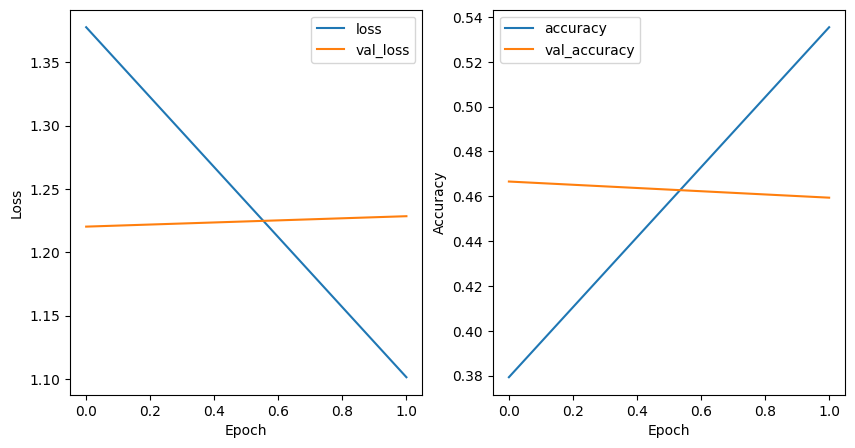

In [ ]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'],
         metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

157/157 [==============================] - 74s 466ms/step


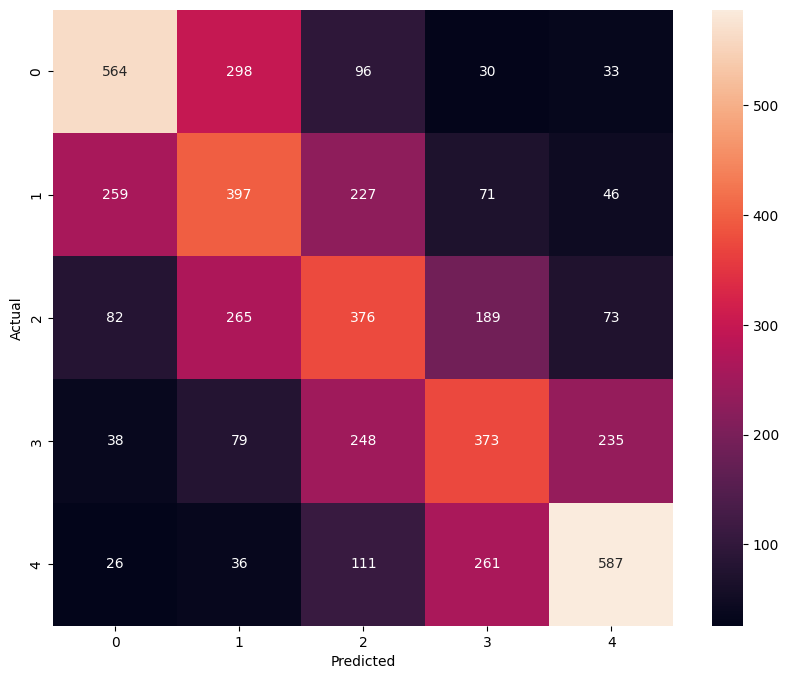

In [ ]:
# converting y_test tht was one hot encoded to one column fo rconfusion matrix
y_true = np.argmax(y_test.values, axis=1)
y_true.shape

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.58      0.55      0.57      1021
           1       0.37      0.40      0.38      1000
           2       0.36      0.38      0.37       985
           3       0.40      0.38      0.39       973
           4       0.60      0.57      0.59      1021

    accuracy                           0.46      5000
   macro avg       0.46      0.46      0.46      5000
weighted avg       0.46      0.46      0.46      5000

